In [16]:
"""
Applicant: Anthony Spalvieri-Kruse
Date: 01/17/2018
Email: ask417@nyu.edu
"""

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

# SK-learn model selection
from sklearn.cross_validation import train_test_split

# SK-learn libraries for learning.
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [3]:
%%bash
ls

loan_timing.csv
problem_statement.pdf
upstart_data_challenge.ipynb


In [4]:
df = pd.read_csv("loan_timing.csv")

df["IsChargeoff"] = np.where(df["days from origination to chargeoff"].isnull(), 0, 1)

df["DaysElapsed"] = np.where(df["days from origination to chargeoff"].isnull(), 
                             df["days since origination"].astype(int, errors="ignore"), 
                             df["days from origination to chargeoff"].astype(int, errors="ignore"))


In [5]:
#Sanity check, chargeoff days elapsed should never be greater than days since origination
df[df["days since origination"] < df["days from origination to chargeoff"]]

,days since origination,days from origination to chargeoff,IsChargeoff,DaysElapsed


In [6]:
#Checking for missing values 
df.isnull().sum()

days since origination                    0
days from origination to chargeoff    46695
IsChargeoff                               0
DaysElapsed                               0
dtype: int64

In [7]:
df.describe()

,days since origination,days from origination to chargeoff,IsChargeoff,DaysElapsed
count,50000.000000,3305.000000,50000.000000,50000.000000
mean,365.844760,214.852345,0.066100,348.701960
std,210.965114,165.233874,0.248459,211.373155
min,0.000000,0.000000,0.000000,0.000000
25%,183.000000,76.000000,0.000000,163.000000
50%,366.000000,180.000000,0.000000,341.000000
75%,549.000000,323.000000,0.000000,530.000000
max,730.000000,725.000000,1.000000,730.000000


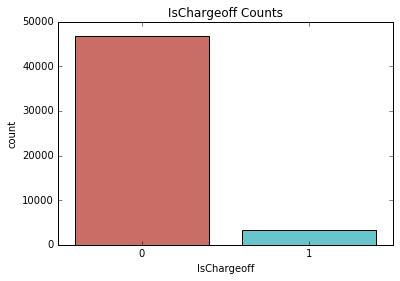

In [8]:
ax = sb.countplot(x="IsChargeoff",data=df, palette='hls')
ax.set_title("IsChargeoff Counts")
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11090f090>,
      dtype=object)

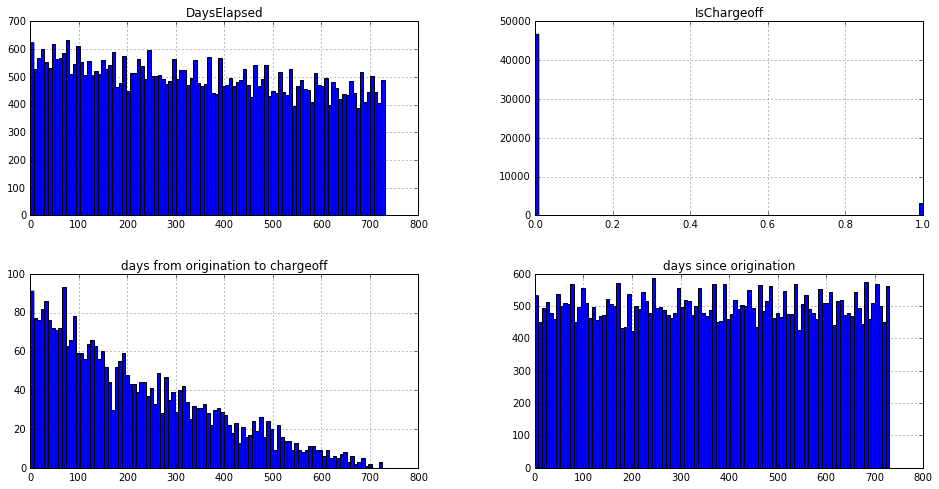

In [9]:
df.hist(figsize=(16,8), bins=100)

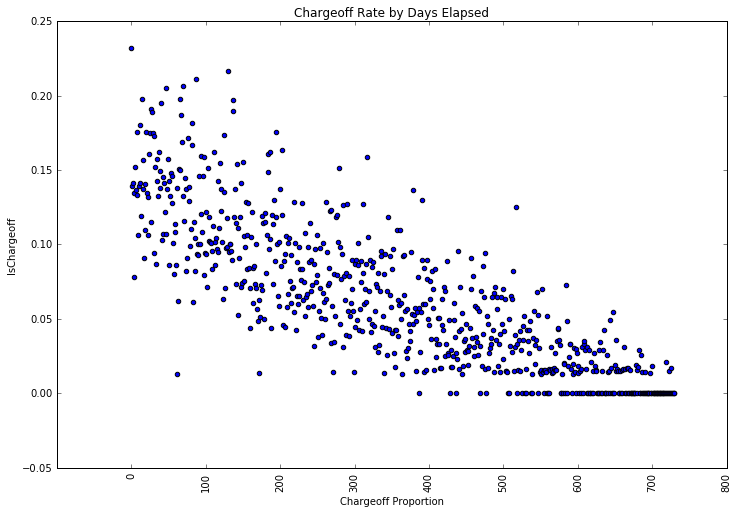

In [10]:
plot = df.groupby("DaysElapsed")["IsChargeoff"].mean()\
                                               .reset_index()\
                                               .plot.scatter(x="DaysElapsed",
                                                             y="IsChargeoff",
                                                             xticks=[0,800],
                                                             figsize=(12,8),
                                                             title="Chargeoff Rate by Days Elapsed")
plot.set_xlabel("Chargeoff Proportion")
plot.set_xticks([i*100 for i in range(9)])
plot.set_xticklabels([i*100 for i in range(9)], rotation=90)

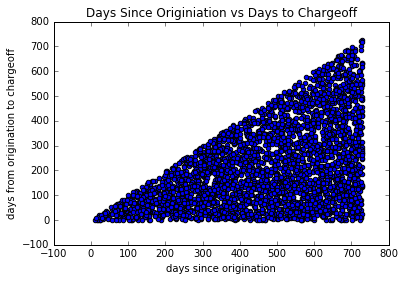

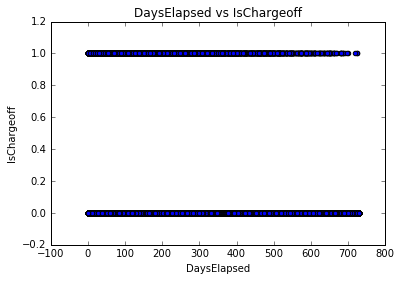

In [11]:
df.plot.scatter(x='days since origination', y="days from origination to chargeoff", 
                 title="Days Since Originiation vs Days to Chargeoff")
df.plot.scatter(x="DaysElapsed", y="IsChargeoff", 
                 title="DaysElapsed vs IsChargeoff")

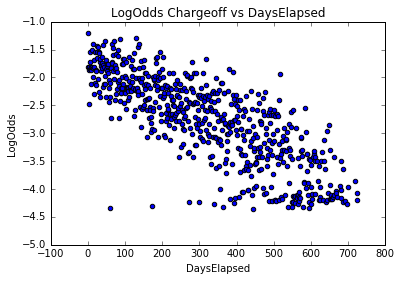

In [35]:
"""
Observation: The longer someone goes without defaulting on their loan, the less likely they are to default 

    We have a fairly uniform distribution of days since origination, but the distribution of chargeoffs appears to be an  
    exponential exponential distribution, plateauing to 0 as we reach the 3 year mark.

    Could model this using logistic regression, where our dependent variable is IsDefault, and our predictor is
    days elapsed since origination for IsDefault=0, else days_from_orig_to_chargeoff

    Assumptions:

        1) Will assume here that the sample is random and drawn from the same population
        2) Binary dependent variable -- this is the case here
        2) Independent Observations -- reasonable assumption, will assume two loan datapoints aren't related
        3) No multicollinearity -- only one predictor, so not an issue
        4) Linearity of predictor variables and log odds.  
            i. Will do a crude test of this below by plotting observed log odds alongside DaysElapsed
        5) Large sample size -- given that we only have a single predictor our sample size is more than large enough
"""

# Plot clearly shows a strong linear relationship between the log odds of a 
# chargeoff and our one predictor variable
probs = df.groupby("DaysElapsed")["IsChargeoff"].mean().reset_index()
probs = probs[probs["IsChargeoff"]!=0]
probs["Odds"] = probs.IsChargeoff/(1-probs.IsChargeoff)
probs["LogOdds"] = np.log(probs["Odds"])
ax = probs.plot.scatter(x="DaysElapsed", y="LogOdds")

ax.set_title("LogOdds Chargeoff vs DaysElapsed")

In [65]:
"""
Because i'm using this model to predict the chargeoff probability as a function of DaysElapsed,  I'm 
omitting a test/train split and performing a regression on all of the data instead.
"""
lr = LogisticRegression()
X = np.reshape(df.DaysElapsed.values,(-1,1))
Y = np.reshape(df.IsChargeoff.values,(-1,1)).ravel()
lr.fit(X, Y)

X_not_yet_charged_off = np.reshape(df["DaysElapsed"][df.IsChargeoff == 0].values,(-1,1))
predictions = lr.predict_proba(X_not_yet_charged_off)
chargeoff_probs = predictions[:,1]
print "Intercept: ", lr.intercept_
print "Coefficient: ", lr.coef_[0]
print "Expectation future chargeoffs: ", sum(chargeoff_probs)
print "With each extra day elapsed since origination, our odds \
of a chargeoff change by a factor of", round(np.exp(result.params)[0],3)

Intercept:  [-1.61603736]
Coefficient:  [-0.00365308]
Expectation future chargeoffs:  2997.7507665416315
With each extra day elapsed since origination, our odds of a chargeoff change by a factor of 0.991


In [ ]:
"""
Conclusion: We've trained a logistic regression model to obtain the probability of chargeoff as a function 
    of DaysElapsed since origination. If we take the probability of a chargeoff given DaysElapsed to be our 
    random variable X_i, assuming our loans are independent, we know that 
        
        E[{X_1,X_2,...,X_N}] = E[X_1] + E[X_2] + ... + E[X_N]

    And we know that for each E[X_i], the expectation of a chargeoff is just the probability of chargeoff computed for 
    the given value of X.  So in this way, we can sum the probability predictions for each value of DaysElapsed, and
    obtain our estimate.  We already see that of the 50000 loans in our sample, 3305 have already charged off.
    Summing the probabilities for the remaining data points, we get an expectation of 2997.75 chargeoffs, so in total
    my model predicts that by the end of the 3 years, we'll have 2997.75 + 3305 ~= 6303 chargeoffs, or 
    100*(6303/50000) = 12.606% of our loans.
"""